# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 15            
model_seed = 5           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.2977 | Test Loss 2.3002 | accs Train 0.1167 Test 0.0831


Epoch 100/3000: Train Loss 0.0080 | Test Loss 1.0598 | accs Train 1.0000 Test 0.6687


Epoch 200/3000: Train Loss 0.0032 | Test Loss 1.1024 | accs Train 1.0000 Test 0.6707


Epoch 300/3000: Train Loss 0.0020 | Test Loss 1.1304 | accs Train 1.0000 Test 0.6692


Epoch 400/3000: Train Loss 0.0014 | Test Loss 1.1514 | accs Train 1.0000 Test 0.6694


Epoch 500/3000: Train Loss 0.0011 | Test Loss 1.1679 | accs Train 1.0000 Test 0.6690


Epoch 600/3000: Train Loss 0.0009 | Test Loss 1.1816 | accs Train 1.0000 Test 0.6686


Epoch 700/3000: Train Loss 0.0008 | Test Loss 1.1932 | accs Train 1.0000 Test 0.6689


Epoch 800/3000: Train Loss 0.0007 | Test Loss 1.2032 | accs Train 1.0000 Test 0.6689


Epoch 900/3000: Train Loss 0.0006 | Test Loss 1.2120 | accs Train 1.0000 Test 0.6687


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.2197 | accs Train 1.0000 Test 0.6685


Epoch 1100/3000: Train Loss 0.0005 | Test Loss 1.2267 | accs Train 1.0000 Test 0.6679


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.2330 | accs Train 1.0000 Test 0.6679


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.2388 | accs Train 1.0000 Test 0.6680


Epoch 1400/3000: Train Loss 0.0004 | Test Loss 1.2440 | accs Train 1.0000 Test 0.6679


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.2488 | accs Train 1.0000 Test 0.6679


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.2532 | accs Train 1.0000 Test 0.6678


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.2573 | accs Train 1.0000 Test 0.6676


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.2611 | accs Train 1.0000 Test 0.6677


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.2647 | accs Train 1.0000 Test 0.6680


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.2680 | accs Train 1.0000 Test 0.6681


Epoch 2100/3000: Train Loss 0.0003 | Test Loss 1.2711 | accs Train 1.0000 Test 0.6682


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.2740 | accs Train 1.0000 Test 0.6679


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.2768 | accs Train 1.0000 Test 0.6679


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.2794 | accs Train 1.0000 Test 0.6678


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.2818 | accs Train 1.0000 Test 0.6679


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.2841 | accs Train 1.0000 Test 0.6677


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.2862 | accs Train 1.0000 Test 0.6675


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.2883 | accs Train 1.0000 Test 0.6676


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.2902 | accs Train 1.0000 Test 0.6674


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.2920 | accs Train 1.0000 Test 0.6674
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3018 | Test Loss 2.3002 | accs Train 0.0933 Test 0.0830


Epoch 100/3000: Train Loss 0.1602 | Test Loss 0.4197 | accs Train 0.9667 Test 0.8697


Epoch 200/3000: Train Loss 0.0323 | Test Loss 0.4429 | accs Train 1.0000 Test 0.8755


Epoch 300/3000: Train Loss 0.0138 | Test Loss 0.4784 | accs Train 1.0000 Test 0.8761


Epoch 400/3000: Train Loss 0.0082 | Test Loss 0.5037 | accs Train 1.0000 Test 0.8763


Epoch 500/3000: Train Loss 0.0057 | Test Loss 0.5225 | accs Train 1.0000 Test 0.8769


Epoch 600/3000: Train Loss 0.0043 | Test Loss 0.5375 | accs Train 1.0000 Test 0.8769


Epoch 700/3000: Train Loss 0.0034 | Test Loss 0.5497 | accs Train 1.0000 Test 0.8768


Epoch 800/3000: Train Loss 0.0028 | Test Loss 0.5601 | accs Train 1.0000 Test 0.8777


Epoch 900/3000: Train Loss 0.0024 | Test Loss 0.5690 | accs Train 1.0000 Test 0.8779


Epoch 1000/3000: Train Loss 0.0021 | Test Loss 0.5768 | accs Train 1.0000 Test 0.8776


Epoch 1100/3000: Train Loss 0.0018 | Test Loss 0.5837 | accs Train 1.0000 Test 0.8772


Epoch 1200/3000: Train Loss 0.0016 | Test Loss 0.5899 | accs Train 1.0000 Test 0.8773


Epoch 1300/3000: Train Loss 0.0015 | Test Loss 0.5954 | accs Train 1.0000 Test 0.8774


Epoch 1400/3000: Train Loss 0.0013 | Test Loss 0.6005 | accs Train 1.0000 Test 0.8770


Epoch 1500/3000: Train Loss 0.0012 | Test Loss 0.6051 | accs Train 1.0000 Test 0.8770


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.6094 | accs Train 1.0000 Test 0.8769


Epoch 1700/3000: Train Loss 0.0011 | Test Loss 0.6133 | accs Train 1.0000 Test 0.8768


Epoch 1800/3000: Train Loss 0.0010 | Test Loss 0.6170 | accs Train 1.0000 Test 0.8765


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.6204 | accs Train 1.0000 Test 0.8761


Epoch 2000/3000: Train Loss 0.0009 | Test Loss 0.6235 | accs Train 1.0000 Test 0.8764


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6264 | accs Train 1.0000 Test 0.8763


Epoch 2200/3000: Train Loss 0.0008 | Test Loss 0.6292 | accs Train 1.0000 Test 0.8764


Epoch 2300/3000: Train Loss 0.0008 | Test Loss 0.6318 | accs Train 1.0000 Test 0.8762


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.6342 | accs Train 1.0000 Test 0.8763


Epoch 2500/3000: Train Loss 0.0007 | Test Loss 0.6365 | accs Train 1.0000 Test 0.8764


Epoch 2600/3000: Train Loss 0.0007 | Test Loss 0.6386 | accs Train 1.0000 Test 0.8765


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6406 | accs Train 1.0000 Test 0.8762


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.6426 | accs Train 1.0000 Test 0.8762


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.6444 | accs Train 1.0000 Test 0.8762


Epoch 3000/3000: Train Loss 0.0006 | Test Loss 0.6461 | accs Train 1.0000 Test 0.8761
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3052 | Test Loss 2.3002 | accs Train 0.0755 Test 0.0819


Epoch 100/3000: Train Loss 0.2694 | Test Loss 0.3501 | accs Train 0.9245 Test 0.8974


Epoch 200/3000: Train Loss 0.1221 | Test Loss 0.3143 | accs Train 0.9715 Test 0.9073


Epoch 300/3000: Train Loss 0.0594 | Test Loss 0.3242 | accs Train 0.9950 Test 0.9097


Epoch 400/3000: Train Loss 0.0313 | Test Loss 0.3429 | accs Train 0.9995 Test 0.9106


Epoch 500/3000: Train Loss 0.0189 | Test Loss 0.3610 | accs Train 1.0000 Test 0.9104


Epoch 600/3000: Train Loss 0.0129 | Test Loss 0.3761 | accs Train 1.0000 Test 0.9101


Epoch 700/3000: Train Loss 0.0095 | Test Loss 0.3886 | accs Train 1.0000 Test 0.9104


Epoch 800/3000: Train Loss 0.0074 | Test Loss 0.3992 | accs Train 1.0000 Test 0.9110


Epoch 900/3000: Train Loss 0.0059 | Test Loss 0.4082 | accs Train 1.0000 Test 0.9114


Epoch 1000/3000: Train Loss 0.0050 | Test Loss 0.4160 | accs Train 1.0000 Test 0.9118


Epoch 1100/3000: Train Loss 0.0042 | Test Loss 0.4229 | accs Train 1.0000 Test 0.9117


Epoch 1200/3000: Train Loss 0.0037 | Test Loss 0.4289 | accs Train 1.0000 Test 0.9120


Epoch 1300/3000: Train Loss 0.0032 | Test Loss 0.4344 | accs Train 1.0000 Test 0.9127


Epoch 1400/3000: Train Loss 0.0029 | Test Loss 0.4393 | accs Train 1.0000 Test 0.9129


Epoch 1500/3000: Train Loss 0.0026 | Test Loss 0.4437 | accs Train 1.0000 Test 0.9131


Epoch 1600/3000: Train Loss 0.0024 | Test Loss 0.4478 | accs Train 1.0000 Test 0.9130


Epoch 1700/3000: Train Loss 0.0022 | Test Loss 0.4515 | accs Train 1.0000 Test 0.9129


Epoch 1800/3000: Train Loss 0.0020 | Test Loss 0.4549 | accs Train 1.0000 Test 0.9134


Epoch 1900/3000: Train Loss 0.0019 | Test Loss 0.4581 | accs Train 1.0000 Test 0.9136


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.4610 | accs Train 1.0000 Test 0.9136


Epoch 2100/3000: Train Loss 0.0016 | Test Loss 0.4637 | accs Train 1.0000 Test 0.9136


Epoch 2200/3000: Train Loss 0.0015 | Test Loss 0.4662 | accs Train 1.0000 Test 0.9137


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4686 | accs Train 1.0000 Test 0.9138


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.4708 | accs Train 1.0000 Test 0.9141


Epoch 2500/3000: Train Loss 0.0013 | Test Loss 0.4728 | accs Train 1.0000 Test 0.9141


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.4747 | accs Train 1.0000 Test 0.9140


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.4765 | accs Train 1.0000 Test 0.9140


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.4783 | accs Train 1.0000 Test 0.9141


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.4799 | accs Train 1.0000 Test 0.9142


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.4814 | accs Train 1.0000 Test 0.9140
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3050 | Test Loss 2.3001 | accs Train 0.0725 Test 0.0822


Epoch 100/3000: Train Loss 0.3282 | Test Loss 0.3423 | accs Train 0.9085 Test 0.8976


Epoch 200/3000: Train Loss 0.2206 | Test Loss 0.2735 | accs Train 0.9388 Test 0.9199


Epoch 300/3000: Train Loss 0.1640 | Test Loss 0.2472 | accs Train 0.9547 Test 0.9257


Epoch 400/3000: Train Loss 0.1228 | Test Loss 0.2306 | accs Train 0.9683 Test 0.9303


Epoch 500/3000: Train Loss 0.0914 | Test Loss 0.2198 | accs Train 0.9787 Test 0.9336


Epoch 600/3000: Train Loss 0.0676 | Test Loss 0.2133 | accs Train 0.9870 Test 0.9359


Epoch 700/3000: Train Loss 0.0496 | Test Loss 0.2096 | accs Train 0.9918 Test 0.9373


Epoch 800/3000: Train Loss 0.0363 | Test Loss 0.2083 | accs Train 0.9953 Test 0.9385


Epoch 900/3000: Train Loss 0.0271 | Test Loss 0.2087 | accs Train 0.9973 Test 0.9401


Epoch 1000/3000: Train Loss 0.0207 | Test Loss 0.2103 | accs Train 0.9988 Test 0.9400


Epoch 1100/3000: Train Loss 0.0163 | Test Loss 0.2124 | accs Train 0.9995 Test 0.9412


Epoch 1200/3000: Train Loss 0.0131 | Test Loss 0.2147 | accs Train 0.9998 Test 0.9416


Epoch 1300/3000: Train Loss 0.0109 | Test Loss 0.2170 | accs Train 1.0000 Test 0.9421


Epoch 1400/3000: Train Loss 0.0092 | Test Loss 0.2192 | accs Train 1.0000 Test 0.9427


Epoch 1500/3000: Train Loss 0.0079 | Test Loss 0.2213 | accs Train 1.0000 Test 0.9434


Epoch 1600/3000: Train Loss 0.0069 | Test Loss 0.2233 | accs Train 1.0000 Test 0.9440


Epoch 1700/3000: Train Loss 0.0061 | Test Loss 0.2251 | accs Train 1.0000 Test 0.9437


Epoch 1800/3000: Train Loss 0.0054 | Test Loss 0.2269 | accs Train 1.0000 Test 0.9438


Epoch 1900/3000: Train Loss 0.0049 | Test Loss 0.2285 | accs Train 1.0000 Test 0.9439


Epoch 2000/3000: Train Loss 0.0044 | Test Loss 0.2300 | accs Train 1.0000 Test 0.9438


Epoch 2100/3000: Train Loss 0.0040 | Test Loss 0.2314 | accs Train 1.0000 Test 0.9437


Epoch 2200/3000: Train Loss 0.0037 | Test Loss 0.2327 | accs Train 1.0000 Test 0.9441


Epoch 2300/3000: Train Loss 0.0034 | Test Loss 0.2339 | accs Train 1.0000 Test 0.9441


Epoch 2400/3000: Train Loss 0.0032 | Test Loss 0.2351 | accs Train 1.0000 Test 0.9440


Epoch 2500/3000: Train Loss 0.0030 | Test Loss 0.2361 | accs Train 1.0000 Test 0.9442


Epoch 2600/3000: Train Loss 0.0028 | Test Loss 0.2372 | accs Train 1.0000 Test 0.9440


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2381 | accs Train 1.0000 Test 0.9441


Epoch 2800/3000: Train Loss 0.0025 | Test Loss 0.2390 | accs Train 1.0000 Test 0.9444


Epoch 2900/3000: Train Loss 0.0024 | Test Loss 0.2398 | accs Train 1.0000 Test 0.9445


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2406 | accs Train 1.0000 Test 0.9445
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3050 | Test Loss 2.3001 | accs Train 0.0715 Test 0.0823


Epoch 100/3000: Train Loss 0.3497 | Test Loss 0.3443 | accs Train 0.8979 Test 0.8993


Epoch 200/3000: Train Loss 0.2582 | Test Loss 0.2691 | accs Train 0.9248 Test 0.9210


Epoch 300/3000: Train Loss 0.2098 | Test Loss 0.2324 | accs Train 0.9381 Test 0.9319


Epoch 400/3000: Train Loss 0.1737 | Test Loss 0.2057 | accs Train 0.9491 Test 0.9384


Epoch 500/3000: Train Loss 0.1452 | Test Loss 0.1852 | accs Train 0.9584 Test 0.9452


Epoch 600/3000: Train Loss 0.1223 | Test Loss 0.1695 | accs Train 0.9668 Test 0.9498


Epoch 700/3000: Train Loss 0.1036 | Test Loss 0.1577 | accs Train 0.9728 Test 0.9547


Epoch 800/3000: Train Loss 0.0882 | Test Loss 0.1486 | accs Train 0.9777 Test 0.9569


Epoch 900/3000: Train Loss 0.0755 | Test Loss 0.1413 | accs Train 0.9816 Test 0.9591


Epoch 1000/3000: Train Loss 0.0648 | Test Loss 0.1355 | accs Train 0.9848 Test 0.9608


Epoch 1100/3000: Train Loss 0.0558 | Test Loss 0.1309 | accs Train 0.9875 Test 0.9630


Epoch 1200/3000: Train Loss 0.0482 | Test Loss 0.1269 | accs Train 0.9896 Test 0.9638


Epoch 1300/3000: Train Loss 0.0417 | Test Loss 0.1238 | accs Train 0.9917 Test 0.9645


Epoch 1400/3000: Train Loss 0.0361 | Test Loss 0.1213 | accs Train 0.9932 Test 0.9656


Epoch 1500/3000: Train Loss 0.0313 | Test Loss 0.1193 | accs Train 0.9946 Test 0.9664


Epoch 1600/3000: Train Loss 0.0272 | Test Loss 0.1178 | accs Train 0.9958 Test 0.9667


Epoch 1700/3000: Train Loss 0.0238 | Test Loss 0.1168 | accs Train 0.9965 Test 0.9673


Epoch 1800/3000: Train Loss 0.0208 | Test Loss 0.1160 | accs Train 0.9971 Test 0.9676


Epoch 1900/3000: Train Loss 0.0183 | Test Loss 0.1155 | accs Train 0.9977 Test 0.9680


Epoch 2000/3000: Train Loss 0.0161 | Test Loss 0.1151 | accs Train 0.9982 Test 0.9681


Epoch 2100/3000: Train Loss 0.0143 | Test Loss 0.1149 | accs Train 0.9987 Test 0.9684


Epoch 2200/3000: Train Loss 0.0128 | Test Loss 0.1149 | accs Train 0.9991 Test 0.9683


Epoch 2300/3000: Train Loss 0.0115 | Test Loss 0.1150 | accs Train 0.9994 Test 0.9687


Epoch 2400/3000: Train Loss 0.0104 | Test Loss 0.1151 | accs Train 0.9997 Test 0.9689


Epoch 2500/3000: Train Loss 0.0094 | Test Loss 0.1154 | accs Train 0.9997 Test 0.9692


Epoch 2600/3000: Train Loss 0.0086 | Test Loss 0.1156 | accs Train 0.9997 Test 0.9694


Epoch 2700/3000: Train Loss 0.0079 | Test Loss 0.1159 | accs Train 0.9998 Test 0.9696


Epoch 2800/3000: Train Loss 0.0073 | Test Loss 0.1162 | accs Train 0.9999 Test 0.9695


Epoch 2900/3000: Train Loss 0.0068 | Test Loss 0.1165 | accs Train 0.9999 Test 0.9696


Epoch 3000/3000: Train Loss 0.0063 | Test Loss 0.1168 | accs Train 0.9999 Test 0.9697
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3044 | Test Loss 2.3001 | accs Train 0.0723 Test 0.0825


Epoch 100/3000: Train Loss 0.3592 | Test Loss 0.3420 | accs Train 0.8953 Test 0.8993


Epoch 200/3000: Train Loss 0.2731 | Test Loss 0.2650 | accs Train 0.9209 Test 0.9232


Epoch 300/3000: Train Loss 0.2281 | Test Loss 0.2255 | accs Train 0.9351 Test 0.9349


Epoch 400/3000: Train Loss 0.1945 | Test Loss 0.1954 | accs Train 0.9446 Test 0.9429


Epoch 500/3000: Train Loss 0.1683 | Test Loss 0.1720 | accs Train 0.9520 Test 0.9508


Epoch 600/3000: Train Loss 0.1475 | Test Loss 0.1539 | accs Train 0.9580 Test 0.9544


Epoch 700/3000: Train Loss 0.1304 | Test Loss 0.1395 | accs Train 0.9634 Test 0.9585


Epoch 800/3000: Train Loss 0.1162 | Test Loss 0.1277 | accs Train 0.9677 Test 0.9625


Epoch 900/3000: Train Loss 0.1042 | Test Loss 0.1181 | accs Train 0.9711 Test 0.9653


Epoch 1000/3000: Train Loss 0.0941 | Test Loss 0.1103 | accs Train 0.9741 Test 0.9669


Epoch 1100/3000: Train Loss 0.0854 | Test Loss 0.1038 | accs Train 0.9765 Test 0.9686


Epoch 1200/3000: Train Loss 0.0779 | Test Loss 0.0983 | accs Train 0.9790 Test 0.9700


Epoch 1300/3000: Train Loss 0.0713 | Test Loss 0.0938 | accs Train 0.9807 Test 0.9716


Epoch 1400/3000: Train Loss 0.0654 | Test Loss 0.0898 | accs Train 0.9824 Test 0.9725


Epoch 1500/3000: Train Loss 0.0602 | Test Loss 0.0865 | accs Train 0.9841 Test 0.9739


Epoch 1600/3000: Train Loss 0.0555 | Test Loss 0.0837 | accs Train 0.9855 Test 0.9746


Epoch 1700/3000: Train Loss 0.0513 | Test Loss 0.0812 | accs Train 0.9868 Test 0.9751


Epoch 1800/3000: Train Loss 0.0475 | Test Loss 0.0791 | accs Train 0.9882 Test 0.9755


Epoch 1900/3000: Train Loss 0.0441 | Test Loss 0.0773 | accs Train 0.9891 Test 0.9763


Epoch 2000/3000: Train Loss 0.0410 | Test Loss 0.0757 | accs Train 0.9902 Test 0.9772


Epoch 2100/3000: Train Loss 0.0382 | Test Loss 0.0743 | accs Train 0.9911 Test 0.9777


Epoch 2200/3000: Train Loss 0.0356 | Test Loss 0.0731 | accs Train 0.9917 Test 0.9782


Epoch 2300/3000: Train Loss 0.0332 | Test Loss 0.0720 | accs Train 0.9923 Test 0.9780


Epoch 2400/3000: Train Loss 0.0311 | Test Loss 0.0712 | accs Train 0.9929 Test 0.9783


Epoch 2500/3000: Train Loss 0.0291 | Test Loss 0.0704 | accs Train 0.9935 Test 0.9787


Epoch 2600/3000: Train Loss 0.0272 | Test Loss 0.0697 | accs Train 0.9940 Test 0.9790


Epoch 2700/3000: Train Loss 0.0255 | Test Loss 0.0691 | accs Train 0.9944 Test 0.9792


Epoch 2800/3000: Train Loss 0.0239 | Test Loss 0.0686 | accs Train 0.9949 Test 0.9797


Epoch 2900/3000: Train Loss 0.0225 | Test Loss 0.0682 | accs Train 0.9955 Test 0.9796


Epoch 3000/3000: Train Loss 0.0211 | Test Loss 0.0678 | accs Train 0.9959 Test 0.9797
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.2920 | accs: 0.6674
 540 samples | Test Loss: 0.6461 | accs: 0.8761
1940 samples | Test Loss: 0.4814 | accs: 0.9140
5940 samples | Test Loss: 0.2406 | accs: 0.9445
19940 samples | Test Loss: 0.1168 | accs: 0.9697
59940 samples | Test Loss: 0.0678 | accs: 0.9797

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0012 | accs: 1.0000
 Model 5940 | Train Loss: 0.0016 | accs: 1.0000
 Model 19940 | Train Loss: 0.0044 | accs: 1.0000
 Model 59940 | Train Loss: 0.0097 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.3268 | accs: 0.6800
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0012 | accs: 1.0000
 Model 5940 | Train Loss: 0.0024 | accs: 1.0000
 Model 19940 | Train Loss: 0.0070 | accs: 1.0000
 Model 59940 | Trai

 Model 1940 | Train Loss: 0.5181 | accs: 0.9090


 Model 5940 | Train Loss: 0.2405 | accs: 0.9476
 Model 19940 | Train Loss: 0.0916 | accs: 0.9773
 Model 59940 | Train Loss: 0.0211 | accs: 0.9960


### Model + Data Specific Verification

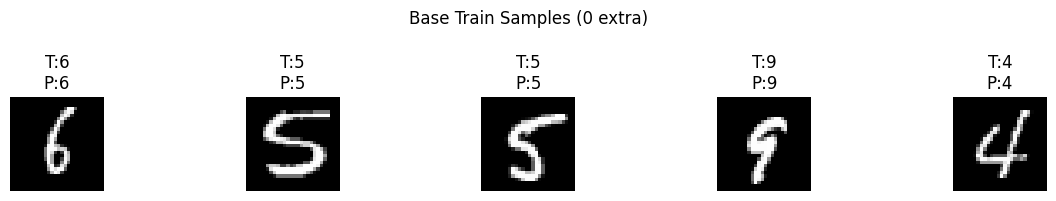

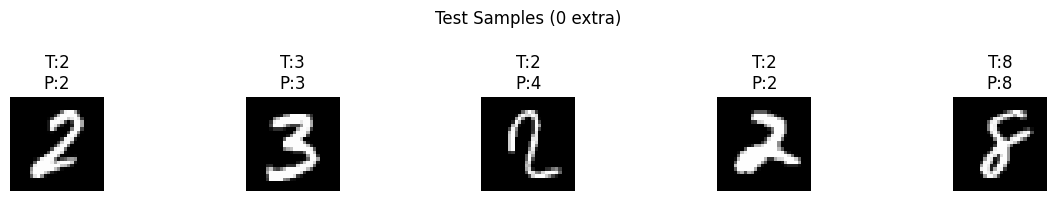

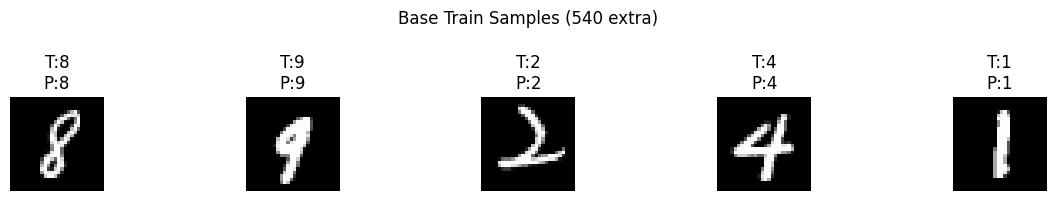

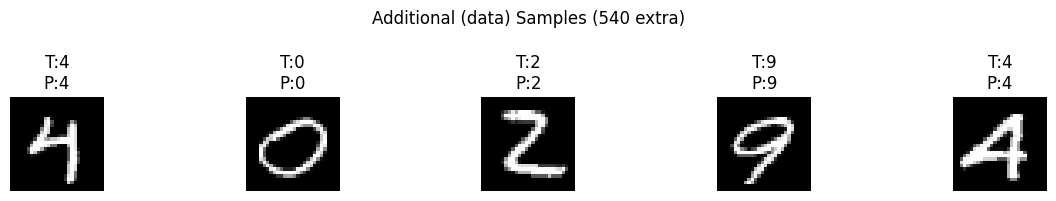

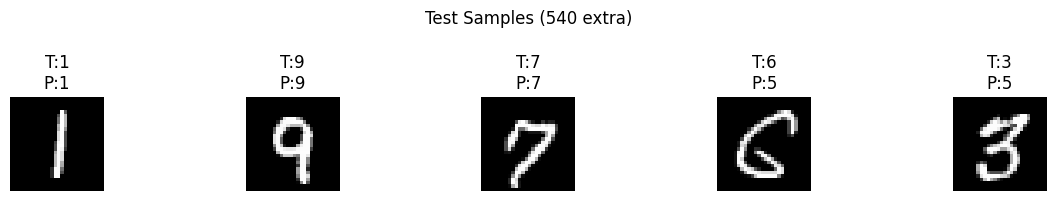

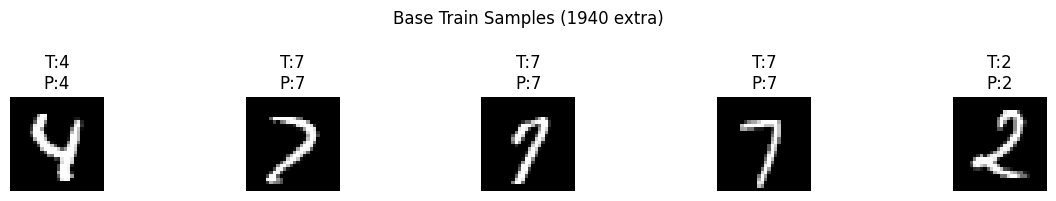

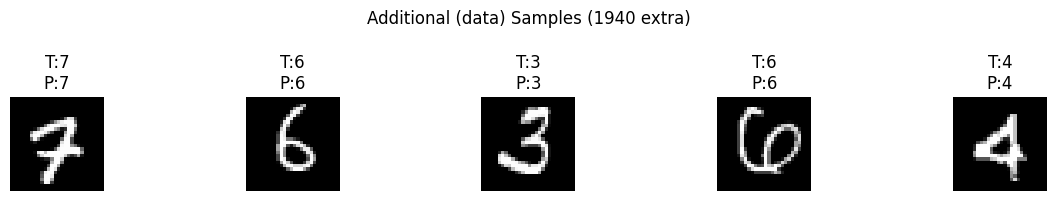

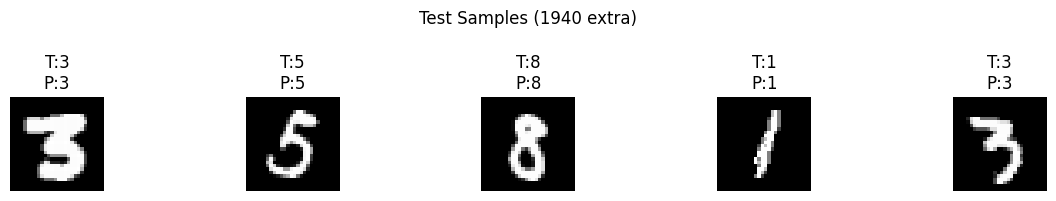

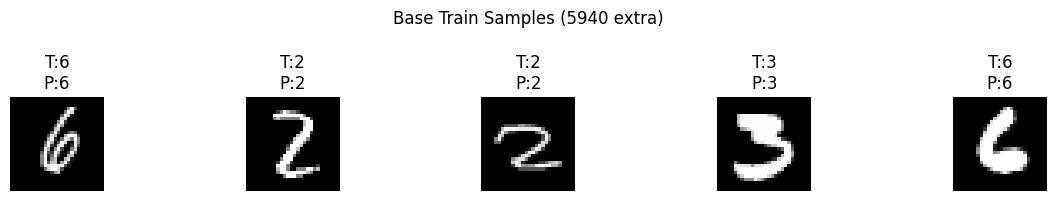

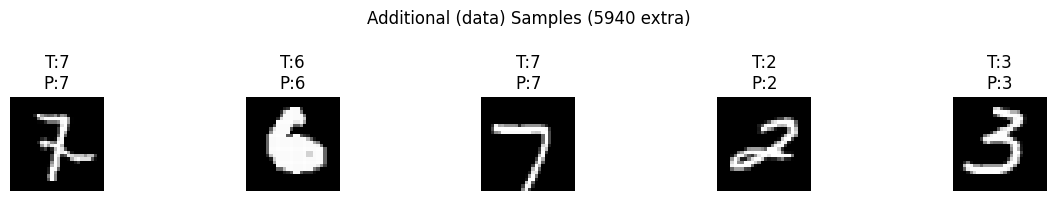

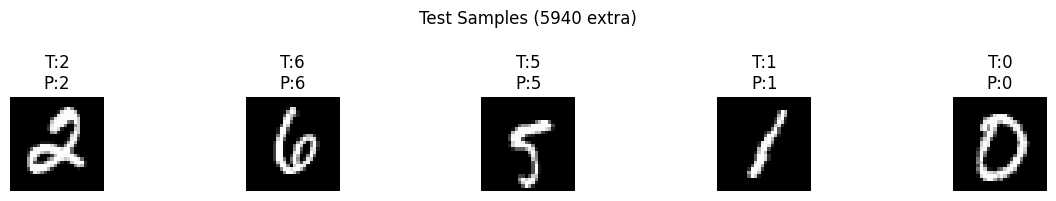

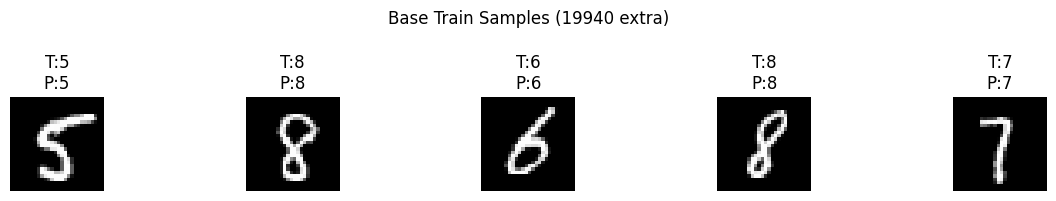

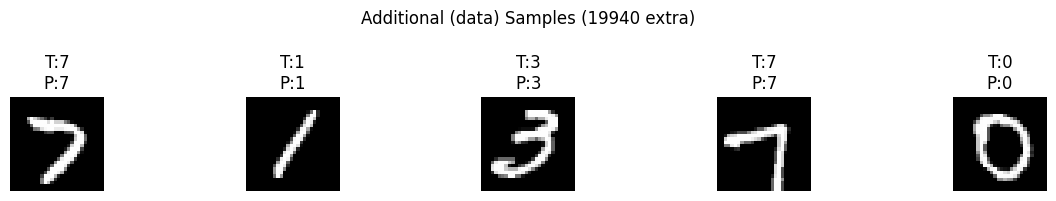

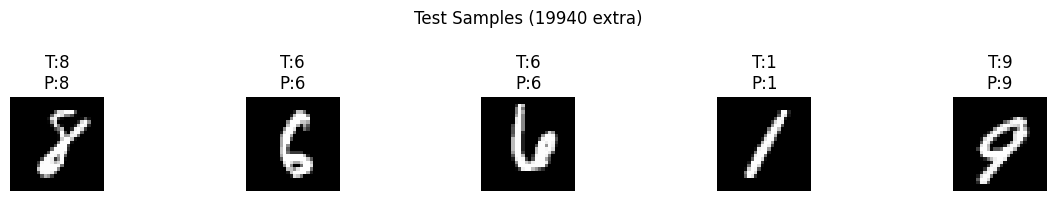

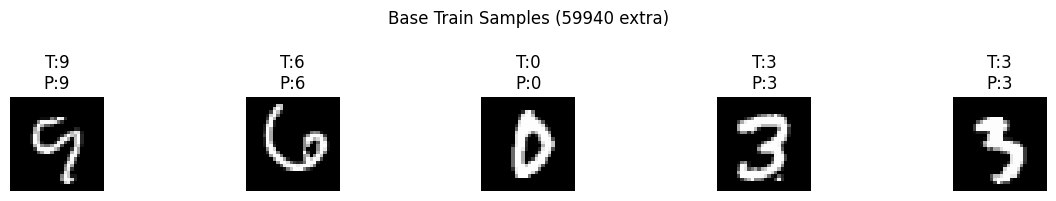

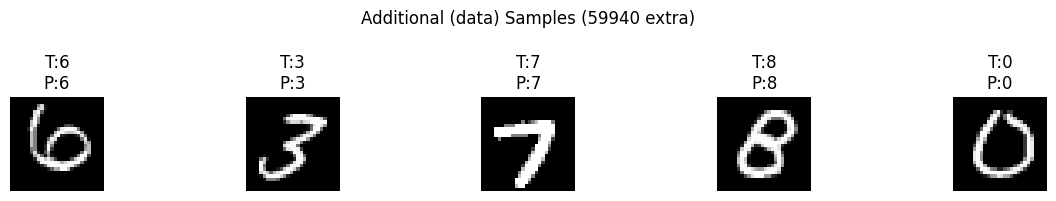

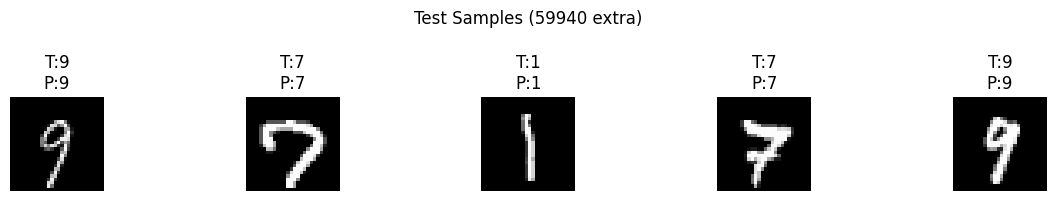

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
